**API Requests**.   
Course: *Advanced Python MDMC Couse 2025*.    
Author: *Marco Prenassi*.   
Licence: *CC BY 4.0 (http://creativecommons.org/licenses/by/4.0)*
#  NAVIGATING DATABANKS - RCSB AND NIH BLAST

## RCSB
### QUERIES
*Let's create a search query using https://www.rcsb.org/docs/programmatic-access/web-services-overview#search-api*.   
*Focusing on a single methodology: "Electron Microscopy" and that include, in the text, Atomic Force [Microscopy]*.   
*Through request_options: paginate, we select only the first 10 rows*.   
*And we request entries as a return type, so we expect the protein ID of RCSB*

In [1]:
query_str = '''
{
  "query": {
    "type": "group",
    "logical_operator": "and",
    "nodes": [
        {
          "type": "terminal",
          "service": "full_text",
          "parameters": {
          "value": "ATOMIC FORCE"
        }
      },
      {
        "type": "terminal",
        "service": "text",
        "parameters": {
          "attribute": "exptl.method",
          "operator": "exact_match",
          "value": "ELECTRON MICROSCOPY"
        }
      }
    ]
  },
  "request_options": {
    "paginate": {
      "start": 0,
      "rows": 10
    }
  },
  "return_type": "entry"
}
'''

### REQUESTS
*We use the module* **requests** *using a POST request to send the query to the API REST interface of rcsb (https://search.rcsb.org/redoc/index.html)*    
*The response of our query contains statistical data (number of rows, and pages) and also the first ten results*.  

In [2]:

import json
import requests
ROW_COUNT = 10
# Load the query string/JSON into a PYTHON dictionary
query = json.loads(query_str)
query['request_options']['paginate']['rows'] = ROW_COUNT

# Post our query to the system
result = requests.post('https://search.rcsb.org/rcsbsearch/v2/query',json=query)
# If you want to know the total number of pages (e.g., to do an automated extraction)
PAGE_MAX = result.json()['total_count']//ROW_COUNT + 1

print("rows: " + str(result.json()['total_count']) + " pages: " + str(PAGE_MAX))
# Let's select the first result:
print(result.json()['result_set'][0])


rows: 14 pages: 2
{'identifier': '7W9W', 'score': 0.8362893446434844}


### GET THE PROTEIN
*Here we use the "GET" request to acquire more precise information about the entry in RCSB, using the IDENTIFIER as a guide to the right URL*.   

In [3]:
identifier = result.json()['result_set'][0]['identifier']
data = requests.get(f'https://data.rcsb.org/rest/v1/core/entry/{identifier}').json()
print("We get a lot of data (and still, is not everything): ")
for labels in data:
  print("\t - "+ labels + ": " + str(data[labels])[:50] + ".......")
print('\n Let\'s focus on the last bit of information:')
print(data['rcsb_external_references'])



We get a lot of data (and still, is not everything): 
	 - audit_author: [{'identifier_orcid': '0000-0002-5887-0055', 'name.......
	 - citation: [{'id': 'primary', 'journal_abbrev': 'Cell', 'jour.......
	 - database2: [{'database_code': '7W9W', 'database_id': 'PDB', '.......
	 - em3d_fitting: [{'id': '1'}].......
	 - em3d_reconstruction: [{'id': '1', 'image_processing_id': '1', 'num_part.......
	 - em_ctf_correction: [{'em_image_processing_id': '1', 'id': '1', 'type'.......
	 - em_entity_assembly: [{'entity_id_list': ['1'], 'id': '1', 'name': 'ChR.......
	 - em_experiment: {'aggregation_state': 'PARTICLE', 'entity_assembly.......
	 - em_image_recording: [{'avg_electron_dose_per_image': 51.533, 'film_or_.......
	 - em_imaging: [{'accelerating_voltage': 300, 'electron_source': .......
	 - em_single_particle_entity: [{'id': 1, 'image_processing_id': '1', 'point_symm.......
	 - em_software: [{'category': 'PARTICLE SELECTION', 'id': '1', 'im.......
	 - em_specimen: [{'embedding_applied': 'NO

### GET THE PROTEIN CCP4 MAP
*We have found the reference of the EM images, now we are going to acquire them*

In [4]:
# Let's extract the emd reference id:
emd_id = data['rcsb_external_references'][0]['id']
print(emd_id)

EMD-32377


*Here we use the RCSB file server (files.rcsb.org) to get our image*


In [5]:
# A little string manipulation to fit the path on the file server
# the emd_file_id (aka the filename) is written like this: emd_number.map.gz,
# while the emd_id is written as EMD-number, so we have to adapt the two strings
# it is a trivial but importan job
print(emd_id)
emd_file_id = emd_id.split('-')[1]
emd_file_id = "emd_" + emd_file_id
# Let's check if it is all right
print(emd_file_id)
# And proceed to make the request
data = requests.get(f'https://files.rcsb.org/pub/emdb/structures/{emd_id}/map/{emd_file_id}.map.gz')
# At the end we are going to save the file locally in a .map.gz file
with open(f'{emd_file_id}.map.gz', 'wb') as fp:
    fp.write(data.content)


EMD-32377
emd_32377


In [6]:
# .map.gz is a compressed file, we must uncompress it with gzip
import gzip
import shutil

with gzip.open(f'{emd_file_id}.map.gz', 'rb') as fp:
  with open(f'{emd_file_id}.map', 'wb') as out:
    shutil.copyfileobj(fp, out)
# Ok, now we have a .map [ccp4] file!

In [7]:
# Let's install gemmi, a tool to read those files https://gemmi.readthedocs.io/en/latest/
!pip install gemmi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.9 MB/s  0:00:00 eta 0:00:01


In [8]:
# And read our file
import gemmi
ccp4_map = gemmi.read_ccp4_map(f'{emd_file_id}.map')
xmap = ccp4_map.grid
#ccp4_map.setup(float('nan'))


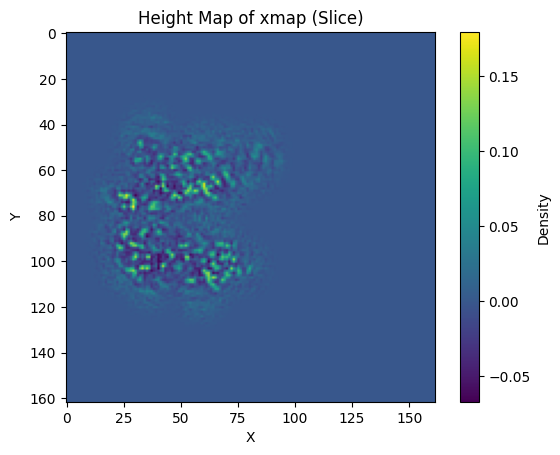

In [10]:
# Let's use matplotlib to plot this file, I was lazy and I asked the AI to do it for me,
# it worked!
# prompt: height map with matplotlib of xmap

import matplotlib.pyplot as plt

# Select a slice along the z-axis (e.g., the middle slice)
slice_index = xmap.array.shape[0] // 2  # Get the middle index along the first axis
slice_data = xmap.array[slice_index, :, :] # Select the slice

plt.imshow(slice_data, cmap='viridis')  # Plot the 2D slice
plt.colorbar(label='Density')
plt.title('Height Map of xmap (Slice)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## BLAST
### RCSB SEQUENCE RETRIEVAL
*In our first request we did not have the protein sequence, let's retrieve it with a request to a different service of the DATA API of RCSB*.   

In [11]:
# The identifier is the same as before
identifier = result.json()['result_set'][0]['identifier']
print ("RCSB protein id: " + identifier)
# Let's get the sequence information
seq_data = requests.get(f'https://data.rcsb.org/rest/v1/core/polymer_entity/{identifier}/1').json()
for labels in seq_data:
  print(str(labels) + ": " + str(seq_data[labels]) + ".......")
# Let's take only the information that we need
print('\n Let\'s focus on pdbx_seq_one_letter_code:')
print("Sequence information: " +  seq_data['entity_poly']['pdbx_seq_one_letter_code'][:42] + "...")

RCSB protein id: 7W9W
entity_poly: {'nstd_linkage': 'no', 'nstd_monomer': 'no', 'pdbx_seq_one_letter_code': 'GPMAHAPGTDQMFYVGTMDGWYLDTKLNSVAIGAHWSCFIVLTITTFYLGYESWTSRGPSKRTSFYAGYQEEQNLALFVNFFAMLSYFGKIVADTLGHNFGDVGPFIIGFGNYRYADYMLTCPMLVYDLLYQLRAPYRVSCSAIIFAILMSGVLAEFYAEGDPRLRNGAYAWYGFGCFWFIFAYSIVMSIVAKQYSRLAQLAQDTGAEHSLHVLKFAVFTFSMLWILFPLVWAICPRGFGWIDDNWTEVAHCVCDIVAKSCYGFALARFRKTYDEELFRLLEQLGHDEDEFQKLELDMRLSSNGERLEVLFQ', 'pdbx_seq_one_letter_code_can': 'GPMAHAPGTDQMFYVGTMDGWYLDTKLNSVAIGAHWSCFIVLTITTFYLGYESWTSRGPSKRTSFYAGYQEEQNLALFVNFFAMLSYFGKIVADTLGHNFGDVGPFIIGFGNYRYADYMLTCPMLVYDLLYQLRAPYRVSCSAIIFAILMSGVLAEFYAEGDPRLRNGAYAWYGFGCFWFIFAYSIVMSIVAKQYSRLAQLAQDTGAEHSLHVLKFAVFTFSMLWILFPLVWAICPRGFGWIDDNWTEVAHCVCDIVAKSCYGFALARFRKTYDEELFRLLEQLGHDEDEFQKLELDMRLSSNGERLEVLFQ', 'pdbx_strand_id': 'A', 'rcsb_artifact_monomer_count': 0, 'rcsb_conflict_count': 0, 'rcsb_deletion_count': 0, 'rcsb_entity_polymer_type': 'Protein', 'rcsb_insertion_count': 0, 'rcsb_mutation_count': 0, 'rcsb_non_std_monomer_count

In [12]:
# full view, useful to copy paste!
print(seq_data['entity_poly']['pdbx_seq_one_letter_code'])

GPMAHAPGTDQMFYVGTMDGWYLDTKLNSVAIGAHWSCFIVLTITTFYLGYESWTSRGPSKRTSFYAGYQEEQNLALFVNFFAMLSYFGKIVADTLGHNFGDVGPFIIGFGNYRYADYMLTCPMLVYDLLYQLRAPYRVSCSAIIFAILMSGVLAEFYAEGDPRLRNGAYAWYGFGCFWFIFAYSIVMSIVAKQYSRLAQLAQDTGAEHSLHVLKFAVFTFSMLWILFPLVWAICPRGFGWIDDNWTEVAHCVCDIVAKSCYGFALARFRKTYDEELFRLLEQLGHDEDEFQKLELDMRLSSNGERLEVLFQ


### BLAST REQUEST
*Let's make a request to Blast, specifically to tblastn, a NIH tool that finds regions of similarity between biological sequences. The program tblastn compares protein sequences to nucleotide sequence databases and calculates the statistical significance.*
https://blast.ncbi.nlm.nih.gov/Blast.cgi

In [13]:
# The requests in blast are a tad more complex,
# We are going to use the module biopython, that has already the function to deal with them
# (RCSB has similar modules too!)
!pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 7.9 MB/s  0:00:00 eta 0:00:01


In [14]:
# Let's make our request
from Bio import Blast
# We select the program tblastn, the databank of Expressed Sequence Tags and we put our sequence data.
result_stream = Blast.qblast("tblastn", "est", seq_data['entity_poly']['pdbx_seq_one_letter_code'])
# and then we wait a bit (could be even up to 1 or 2 minutes)

In [ ]:
# We read the stream
res = result_stream.read()
print(res[:150])

# BEWARE, when you read the stream and then close it, it disappear (it's a stream, after all) and you have to start over from the last block (redo the request)
with open("blast.xml", "wb") as fp:
  fp.write(res)
# Let's read something!


NameError: name 'result_stream' is not defined

### READ THE RESULTS


In [ ]:
# We requested the results as the default type which is an XML document, we need a specific module to read them
!pip install xmltodict


In [ ]:
import xmltodict
# Let's open the file
with open("blast.xml", "r") as fp:
    blast_res = fp.read()
blast_results = xmltodict.parse(blast_res)


In [ ]:
# Let's check the first result:
first_result = blast_results['BlastOutput']['BlastOutput_iterations']['Iteration']['Iteration_hits']['Hit'][0]
print(f"{first_result['Hit_num']}: {first_result['Hit_def']}")
print(f"QSEQ:\t\t{first_result['Hit_hsps']['Hsp']['Hsp_qseq']} ")
print(f"HSEQ:\t\t{first_result['Hit_hsps']['Hsp']['Hsp_hseq']} ")
print(f"Midline:\t{first_result['Hit_hsps']['Hsp']['Hsp_midline']} ")

1: HE989719 Guillardia theta CCMP 327 Guillardia theta cDNA clone GT50c04, mRNA sequence
QSEQ:		NSVAIGAHWSCFIVLTITTFYLGYESWTSRGPSKRTSFYAGYQEEQNLALFVNFFAMLSYFGKIVADTLGHNFGDVGPFIIGFGNYRYADYMLTCPMLVYDLLYQLRAPYRVSCSAIIFAILMSGVLAEFYAEGDPRLRNGAYAWYGFGCFWFIFAYSIVMSIVAKQYSRLAQLAQDTGAEHSLHVLKFAVFTFSMLWILFPLVWAICPRGFGWIDDNWTEVAHCVCDIVAKSCY 
HSEQ:		NPIVIAADWIGFIALFGSSLAVAYKLVTFKGPDQGDVYFFGYREEKMISVFVNLFAALAYWAKLAS----HANGDVGP-AASVTTYKYLDYLFTCPLLTIDLLWCLNLPYKFTFGAIVAVCILCAFMASVI---PPPAR---YMWFGMGITVFSTAWFNILKLVRM---RLEQFVSKEAKEVR-QSLKVACMTYFFIWLGYPTLWVLGDAGV--LDSVVSALLHTFLDVFSKSIY 
Midline:	N + I A W  FI L  ++  + Y+  T +GP +   ++ GY+EE+ +++FVN FA L+Y+ K+ +    H  GDVGP       Y+Y DY+ TCP+L  DLL+ L  PY+ +  AI+   ++   +A       P  R   Y W+G G   F  A+  ++ +V     RL Q       E     LK A  T+  +W+ +P +W +   G   +D   + + H   D+ +KS Y 
